In [1]:
import pandas as pd
import numpy as np
import datetime

from pyspark.sql import  SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark import SQLContext
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import year, month, dayofmonth

import matplotlib as plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic


# LSTM
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

/usr/local/anaconda/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/anaconda/python2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

# Transaction & Store Data

In [194]:
transaction_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/transactions_store44.csv",header = True,inferSchema = True)

In [195]:
stores_data=sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/stores.csv",header = True,inferSchema = True)

In [196]:
stores_data

DataFrame[store_nbr: int, city: string, state: string, type: string, cluster: int]

In [197]:
sales_df =pd.merge(transaction_data.toPandas(),stores_data.toPandas(),how='left')
sales_df.describe()

,store_nbr,transactions,cluster
count,1089.0,1089.000000,1089.0
mean,44.0,4325.125803,5.0
std,0.0,749.300106,0.0
min,44.0,2333.000000,5.0
25%,44.0,3797.000000,5.0
50%,44.0,4133.000000,5.0
75%,44.0,4787.000000,5.0
max,44.0,8359.000000,5.0


In [198]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-02,44,4821,Quito,Pichincha,A,5
1,2013-01-03,44,3618,Quito,Pichincha,A,5
2,2013-01-04,44,4169,Quito,Pichincha,A,5
3,2013-01-05,44,4921,Quito,Pichincha,A,5
4,2013-01-06,44,4925,Quito,Pichincha,A,5


In [199]:
sales_df.date.min()

Timestamp('2013-01-02 00:00:00')

In [200]:
sales_df.date.max()

Timestamp('2015-12-31 00:00:00')

# Holiday Data

In [201]:
holiday_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/holidays_events_2013_2015.csv",header = True,inferSchema = True)
holiday_data_df = holiday_data.toPandas()

In [202]:
holiday_data_df.head(2)

,date,type,locale,locale_name,description,transferred
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False


In [203]:
holiday_data_df['date'] = pd.to_datetime(holiday_data_df['date'], format='%b %d, %Y')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%b %d, %Y')

In [204]:
# Isolating events that do not correspond to holidays
events=holiday_data_df.loc[holiday_data_df.type=='Event']
holiday_data_df=holiday_data_df.loc[holiday_data_df.type!='Event']

In [205]:
# Adjuusting this variable to show all holidays
sales_df['year'],sales_df['week'],sales_df['day']=list(zip(*sales_df.date.apply(lambda x: x.isocalendar())))

# Creating a categorical variable showing weekends
sales_df['dayoff']=[x in [6,7] for x in sales_df.day]

# Adjuusting this variable to show all holidays
for (d,t,l,n) in zip(holiday_data_df.date,holiday_data_df.type,holiday_data_df.locale,holiday_data_df.locale_name):
  if t!='Work Day':
    if l=='National':
      sales_df.loc[sales_df.date==d,'dayoff']=True
    elif l=='Regional':
      sales_df.loc[(sales_df.date==d)&(sales_df.state==n),'dayoff']=True
    else:
      sales_df.loc[(sales_df.date==d)&(sales_df.city==n),'dayoff']=True
  else:
    sales_df.loc[(sales_df.date==d),'dayoff']=False

In [206]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1088
Data columns (total 11 columns):
date            1089 non-null datetime64[ns]
store_nbr       1089 non-null int64
transactions    1089 non-null int64
city            1089 non-null object
state           1089 non-null object
type            1089 non-null object
cluster         1089 non-null int64
year            1089 non-null int64
week            1089 non-null int64
day             1089 non-null int64
dayoff          1089 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(6), object(3)
memory usage: 94.6+ KB


In [207]:
holiday_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 169
Data columns (total 6 columns):
date           149 non-null datetime64[ns]
type           149 non-null object
locale         149 non-null object
locale_name    149 non-null object
description    149 non-null object
transferred    149 non-null bool
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 7.1+ KB


In [208]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff
0,2013-01-02,44,4821,Quito,Pichincha,A,5,2013,1,3,False
1,2013-01-03,44,3618,Quito,Pichincha,A,5,2013,1,4,False
2,2013-01-04,44,4169,Quito,Pichincha,A,5,2013,1,5,False
3,2013-01-05,44,4921,Quito,Pichincha,A,5,2013,1,6,False
4,2013-01-06,44,4925,Quito,Pichincha,A,5,2013,1,7,True


In [209]:
sales_df.count()

date            1089
store_nbr       1089
transactions    1089
city            1089
state           1089
type            1089
cluster         1089
year            1089
week            1089
day             1089
dayoff          1089
dtype: int64

# Oil Data

In [210]:
sdfOil = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/oil.csv",header = True,inferSchema = True)

# Train Data

In [211]:
train_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/train_store44.csv",header = True,inferSchema = True)

In [212]:
sqlContext.registerDataFrameAsTable(train_data, "traintbl")
train_2015 = sqlContext.sql("select *  from traintbl where date < '2016-01-01 00:00:00'")

In [213]:
train_2015.head(2)

[Row(id=32292, date=datetime.datetime(2013, 1, 2, 0, 0), store_nbr=44, item_nbr=103520, unit_sales=12.0, onpromotion=None),
 Row(id=32293, date=datetime.datetime(2013, 1, 2, 0, 0), store_nbr=44, item_nbr=103665, unit_sales=20.0, onpromotion=None)]

In [214]:
#trainTbl2015 = sqlContext.sql("SELECT date as date,(sum(unit_sales)*count(item_nbr)) as total_sales from traintbl where year(date) <='2015' group by date order by date ")
#trainTbl2015.show()

In [215]:
# Onpromotion field can't be used as it is strongly associated with Item_nbr
#trainTbl2015 = sqlContext.sql("SELECT date as date,(sum(unit_sales)) as total_sales,onpromotion as onpromotion from traintbl where year(date) <='2015'  group by date,onpromotion order by date ")
#trainTbl2015.show()
#trainTbl2015 = trainTbl2015.fillna({'onpromotion':0})

In [216]:
trainTbl2015 = sqlContext.sql("SELECT date as date,(sum(unit_sales)) as total_sales from traintbl where year(date) <='2015'  group by date order by date ")
trainTbl2015.show()

+-------------------+------------------+
|               date|       total_sales|
+-------------------+------------------+
|2013-01-02 00:00:00|         30095.181|
|2013-01-03 00:00:00|20447.056999999997|
|2013-01-04 00:00:00|22795.799000000003|
|2013-01-05 00:00:00|31382.508000000005|
|2013-01-06 00:00:00|         36069.345|
|2013-01-07 00:00:00|         21025.329|
|2013-01-08 00:00:00|         33993.257|
|2013-01-09 00:00:00|         21296.042|
|2013-01-10 00:00:00|15522.827999999998|
|2013-01-11 00:00:00|19738.474999999995|
|2013-01-12 00:00:00|         25418.678|
|2013-01-13 00:00:00|31129.350000000002|
|2013-01-14 00:00:00| 17518.41199999999|
|2013-01-15 00:00:00|15761.720999999996|
|2013-01-16 00:00:00|21994.872999999996|
|2013-01-17 00:00:00|14999.144999999997|
|2013-01-18 00:00:00|         19238.575|
|2013-01-19 00:00:00|29145.704000000005|
|2013-01-20 00:00:00|31897.753000000004|
|2013-01-21 00:00:00|17632.768000000007|
+-------------------+------------------+
only showing top

In [217]:
type(trainTbl2015)

pyspark.sql.dataframe.DataFrame

In [218]:
train_df =pd.merge(trainTbl2015.toPandas(),sales_df,how='left')
train_df.describe()

,total_sales,store_nbr,transactions,cluster,year,week,day
count,1089.000000,1089.0,1089.000000,1089.0,1089.000000,1089.000000,1089.000000
mean,32352.572317,44.0,4325.125803,5.0,2014.004591,26.620753,4.000000
std,13420.765145,0.0,749.300106,0.0,0.817421,14.982047,2.003214
min,9067.748000,44.0,2333.000000,5.0,2013.000000,1.000000,1.000000
25%,21326.734000,44.0,3797.000000,5.0,2013.000000,14.000000,2.000000
50%,30586.076000,44.0,4133.000000,5.0,2014.000000,27.000000,4.000000
75%,39148.231000,44.0,4787.000000,5.0,2015.000000,40.000000,6.000000
max,78070.753000,44.0,8359.000000,5.0,2015.000000,53.000000,7.000000


In [219]:
train_df.head()

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,False
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,False
2,2013-01-04,22795.799,44,4169,Quito,Pichincha,A,5,2013,1,5,False
3,2013-01-05,31382.508,44,4921,Quito,Pichincha,A,5,2013,1,6,False
4,2013-01-06,36069.345,44,4925,Quito,Pichincha,A,5,2013,1,7,True


In [220]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1088
Data columns (total 12 columns):
date            1089 non-null datetime64[ns]
total_sales     1089 non-null float64
store_nbr       1089 non-null int64
transactions    1089 non-null int64
city            1089 non-null object
state           1089 non-null object
type            1089 non-null object
cluster         1089 non-null int64
year            1089 non-null int64
week            1089 non-null int64
day             1089 non-null int64
dayoff          1089 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 103.2+ KB


In [221]:
# Adding feature - Taking 7 lags for prediction LSTM
for obs in range(1,8):
  train_df['T_'+ str(obs)]=train_df.transactions.shift(obs)

In [222]:
train_df.head(6)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,False,4821.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,22795.799,44,4169,Quito,Pichincha,A,5,2013,1,5,False,3618.0,4821.0,NaN,NaN,NaN,NaN,NaN
3,2013-01-05,31382.508,44,4921,Quito,Pichincha,A,5,2013,1,6,False,4169.0,3618.0,4821.0,NaN,NaN,NaN,NaN
4,2013-01-06,36069.345,44,4925,Quito,Pichincha,A,5,2013,1,7,True,4921.0,4169.0,3618.0,4821.0,NaN,NaN,NaN
5,2013-01-07,21025.329,44,3871,Quito,Pichincha,A,5,2013,2,1,False,4925.0,4921.0,4169.0,3618.0,4821.0,NaN,NaN


In [223]:
#train_df.onpromotion=train_df.onpromotion.astype('int')
train_df.dayoff=train_df.dayoff.astype('int')
train_df.date = pd.to_datetime(train_df.date)
train_df =train_df.fillna(0)

In [224]:
train_df.head(10)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,0,4821.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-04,22795.799,44,4169,Quito,Pichincha,A,5,2013,1,5,0,3618.0,4821.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-05,31382.508,44,4921,Quito,Pichincha,A,5,2013,1,6,0,4169.0,3618.0,4821.0,0.0,0.0,0.0,0.0
4,2013-01-06,36069.345,44,4925,Quito,Pichincha,A,5,2013,1,7,1,4921.0,4169.0,3618.0,4821.0,0.0,0.0,0.0
5,2013-01-07,21025.329,44,3871,Quito,Pichincha,A,5,2013,2,1,0,4925.0,4921.0,4169.0,3618.0,4821.0,0.0,0.0
6,2013-01-08,33993.257,44,3593,Quito,Pichincha,A,5,2013,2,2,0,3871.0,4925.0,4921.0,4169.0,3618.0,4821.0,0.0
7,2013-01-09,21296.042,44,4006,Quito,Pichincha,A,5,2013,2,3,0,3593.0,3871.0,4925.0,4921.0,4169.0,3618.0,4821.0
8,2013-01-10,15522.828,44,3323,Quito,Pichincha,A,5,2013,2,4,0,4006.0,3593.0,3871.0,4925.0,4921.0,4169.0,3618.0
9,2013-01-11,19738.475,44,3873,Quito,Pichincha,A,5,2013,2,5,0,3323.0,4006.0,3593.0,3871.0,4925.0,4921.0,4169.0


In [225]:
ts=train_df[['date','transactions']].set_index('date')

In [226]:
ts=ts.transactions.astype('float')

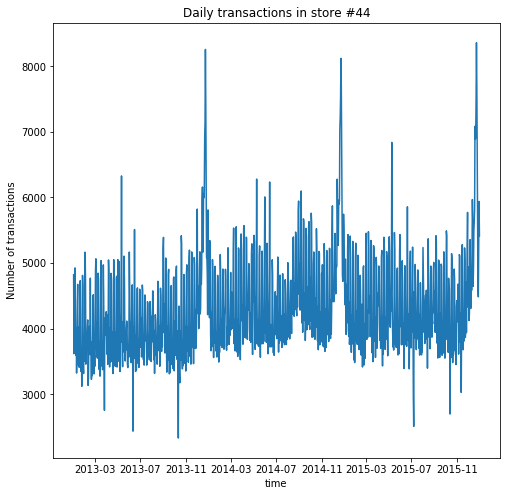

In [227]:
plt.figure(figsize=(8,8))
plt.title('Daily transactions in store #44')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);

In [228]:
xmask=(train_df.date>=pd.to_datetime("12/01/2015")) & (train_df.date<=pd.to_datetime("12/30/2015"))


In [229]:
xmas_month=train_df.loc[xmask]

In [230]:
xmas_month=xmas_month[['date','transactions']].set_index('date')


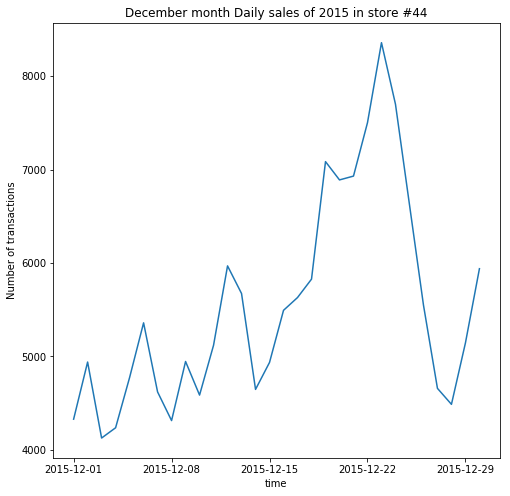

In [231]:
plt.figure(figsize=(8,8))
plt.title('December month Daily sales of 2015 in store #44')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(xmas_month);
# First week of october has the highest sales in 2015, after 10th sales goes down drastically till 15th

In [232]:
clean_data=train_df[['day','dayoff','T_1','T_2','T_3','T_4','T_5','T_6','T_7','transactions']]

In [233]:
clean_data.head(6)

,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7,transactions
0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4821
1,4,0,4821.0,0.0,0.0,0.0,0.0,0.0,0.0,3618
2,5,0,3618.0,4821.0,0.0,0.0,0.0,0.0,0.0,4169
3,6,0,4169.0,3618.0,4821.0,0.0,0.0,0.0,0.0,4921
4,7,1,4921.0,4169.0,3618.0,4821.0,0.0,0.0,0.0,4925
5,1,0,4925.0,4921.0,4169.0,3618.0,4821.0,0.0,0.0,3871


In [234]:
# Predict with validation_split=0.3
X_clean_data=clean_data[['day','dayoff','T_1','T_2','T_3','T_4','T_5','T_6','T_7']]
Y_clean_data=clean_data['transactions']

In [235]:
scaler=StandardScaler()
X_clean_data_scaled=scaler.fit_transform(X_clean_data)
Y_clean_data_scaled=scaler.fit_transform(Y_clean_data.reshape(len(Y_clean_data),1))

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [236]:
X_clean_reshaped=X_clean_data_scaled.reshape((X_clean_data_scaled.shape[0],1,X_clean_data_scaled.shape[1]))

In [237]:
model=Sequential()
model.add(LSTM(5,input_shape=(1,9),kernel_initializer='normal',activation='relu')) # 5 memory cells
model.add(Dense(1,kernel_initializer='normal'))
model.compile(loss='mean_squared_error',optimizer='adam')

In [238]:
history=model.fit(X_clean_reshaped,Y_clean_data_scaled,validation_split=0.3,
                  epochs=50,batch_size=7,verbose=2) # Every 7 records updates weights in each iteration

#- around 26%  - 1s  - 0s - loss: 0.2149 - val_loss: 0.2637  for 50th iteration

Train on 762 samples, validate on 327 samples
Epoch 1/50
 - 2s - loss: 0.9641 - val_loss: 0.9380
Epoch 2/50
 - 1s - loss: 0.7542 - val_loss: 0.5945
Epoch 3/50
 - 1s - loss: 0.4846 - val_loss: 0.4079
Epoch 4/50
 - 1s - loss: 0.3789 - val_loss: 0.3638
Epoch 5/50
 - 1s - loss: 0.3501 - val_loss: 0.3536
Epoch 6/50
 - 1s - loss: 0.3277 - val_loss: 0.3403
Epoch 7/50
 - 1s - loss: 0.3141 - val_loss: 0.3335
Epoch 8/50
 - 1s - loss: 0.3037 - val_loss: 0.3270
Epoch 9/50
 - 1s - loss: 0.2956 - val_loss: 0.3209
Epoch 10/50
 - 1s - loss: 0.2877 - val_loss: 0.3166
Epoch 11/50
 - 1s - loss: 0.2804 - val_loss: 0.3120
Epoch 12/50
 - 1s - loss: 0.2762 - val_loss: 0.3078
Epoch 13/50
 - 1s - loss: 0.2697 - val_loss: 0.3031
Epoch 14/50
 - 1s - loss: 0.2662 - val_loss: 0.2995
Epoch 15/50
 - 1s - loss: 0.2622 - val_loss: 0.2965
Epoch 16/50
 - 1s - loss: 0.2589 - val_loss: 0.2913
Epoch 17/50
 - 1s - loss: 0.2567 - val_loss: 0.2881
Epoch 18/50
 - 0s - loss: 0.2525 - val_loss: 0.2855
Epoch 19/50
 - 1s - loss: 0

In [239]:

training_data =train_df[train_df.date < pd.to_datetime("01/01/2014")]
val_mask=(train_df.date >= pd.to_datetime("01/01/2014") ) & (train_df.date < pd.to_datetime("01/01/2015"))
val_data=train_df.loc[val_mask]
test_data=train_df[train_df.date >= pd.to_datetime("01/01/2015")]

In [240]:
training_data.head(2)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,0,4821.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
val_data.head(2)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7
363,2014-01-02,47024.6300,44,4422,Quito,Pichincha,A,5,2014,1,4,0,5085.0,5810.0,4214.0,4822.0,5087.0,5084.0,7433.0
364,2014-01-03,42599.8299,44,4167,Quito,Pichincha,A,5,2014,1,5,0,4422.0,5085.0,5810.0,4214.0,4822.0,5087.0,5084.0


In [242]:
test_data.tail(2)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7
1087,2015-12-30,54848.641,44,5938,Quito,Pichincha,A,5,2015,53,3,0,5143.0,4485.0,4656.0,5549.0,7700.0,8359.0,7502.0
1088,2015-12-31,40408.634,44,5414,Quito,Pichincha,A,5,2015,53,4,1,5938.0,5143.0,4485.0,4656.0,5549.0,7700.0,8359.0


In [243]:
clean_train=training_data[['day','dayoff','T_1','T_2','T_3','T_4','T_5','T_6','T_7','transactions']]
clean_val=val_data[['day','dayoff','T_1','T_2','T_3','T_4','T_5','T_6','T_7','transactions']]
clean_test=test_data[['day','dayoff','T_1','T_2','T_3','T_4','T_5','T_6','T_7','transactions']]

In [244]:
clean_train.head(2)

,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7,transactions
0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4821
1,4,0,4821.0,0.0,0.0,0.0,0.0,0.0,0.0,3618


In [245]:
clean_val.head(2)

,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7,transactions
363,4,0,5085.0,5810.0,4214.0,4822.0,5087.0,5084.0,7433.0,4422
364,5,0,4422.0,5085.0,5810.0,4214.0,4822.0,5087.0,5084.0,4167


In [246]:
clean_test.head(2)

,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7,transactions
726,5,1,5524.0,5745.0,4868.0,4721.0,4813.0,5693.0,7689.0,4621
727,6,1,4621.0,5524.0,5745.0,4868.0,4721.0,4813.0,5693.0,4364


In [247]:
X_train,y_train= clean_train.drop(["transactions"],axis=1),clean_train.transactions
X_test,y_test= clean_test.drop(["transactions"],axis=1),clean_test.transactions
X_val,y_val= clean_val.drop(["transactions"],axis=1),clean_val.transactions


In [248]:
X_train.head(2)

,day,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7
0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0,4821.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
# Normalize/Standardize the input and output  data

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)
X_val_scaled=scaler.fit_transform(X_val)

y_train_scaled=scaler.fit_transform(y_train.reshape(len(y_train),1))
y_test_scaled=scaler.fit_transform(y_test.reshape(len(y_test),1))
y_val_scaled=scaler.fit_transform(y_val.reshape(len(y_val),1))

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


In [250]:
X_train_scaled.shape

(363, 9)

In [251]:
X_train_scaled

array([[-5.00860734e-01, -6.80962317e-01, -5.40475770e+00, ...,
        -4.68493780e+00, -4.54275502e+00, -4.48418970e+00],
       [-1.37599103e-03, -6.80962317e-01,  9.48111523e-01, ...,
        -4.68493780e+00, -4.54275502e+00, -4.48418970e+00],
       [ 4.98108752e-01, -6.80962317e-01, -6.37140847e-01, ...,
        -4.68493780e+00, -4.54275502e+00, -4.48418970e+00],
       ...,
       [ 1.49707824e+00,  1.46851004e+00,  9.49429273e-01, ...,
         4.87343068e+00,  3.52193466e+00,  3.22768415e+00],
       [-1.49983022e+00, -6.80962317e-01,  1.48237717e-01, ...,
         3.92060398e+00,  4.75771684e+00,  3.51715884e+00],
       [-1.00034548e+00,  1.46851004e+00,  2.25136555e+00, ...,
         1.20105364e+00,  3.83059858e+00,  4.74323501e+00]])

In [252]:
X_test_scaled.shape

(363, 9)

In [253]:
X_val_scaled.shape

(363, 9)

In [254]:
# LSTM accepts inputs in 3 Dimension format i.e  Samples, Time steps, feautes
X_t_reshaped=X_train_scaled.reshape((X_train_scaled.shape[0],1,X_train_scaled.shape[1]))
X_val_reshaped=X_val_scaled.reshape((X_val_scaled.shape[0],1,X_val_scaled.shape[1]))

In [255]:
X_t_reshaped.shape

(363, 1, 9)

In [256]:
model2=Sequential()
model2.add(LSTM(5,input_shape=(1,9),kernel_initializer='normal',activation='relu'))
model2.add(Dense(1,kernel_initializer='normal'))
model2.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse']) 
# Manual validation
history=model2.fit(X_t_reshaped,y_train_scaled,validation_data=(X_val_reshaped,y_val_scaled),
                  epochs=150,batch_size=7,verbose=2)


Train on 363 samples, validate on 363 samples
Epoch 1/150
 - 2s - loss: 0.9941 - mean_squared_error: 0.9941 - val_loss: 0.9833 - val_mean_squared_error: 0.9833
Epoch 2/150
 - 1s - loss: 0.9658 - mean_squared_error: 0.9658 - val_loss: 0.9248 - val_mean_squared_error: 0.9248
Epoch 3/150
 - 1s - loss: 0.8762 - mean_squared_error: 0.8762 - val_loss: 0.7762 - val_mean_squared_error: 0.7762
Epoch 4/150
 - 1s - loss: 0.7049 - mean_squared_error: 0.7049 - val_loss: 0.5854 - val_mean_squared_error: 0.5854
Epoch 5/150
 - 1s - loss: 0.5462 - mean_squared_error: 0.5462 - val_loss: 0.4571 - val_mean_squared_error: 0.4571
Epoch 6/150
 - 1s - loss: 0.4603 - mean_squared_error: 0.4603 - val_loss: 0.3856 - val_mean_squared_error: 0.3856
Epoch 7/150
 - 1s - loss: 0.4146 - mean_squared_error: 0.4146 - val_loss: 0.3545 - val_mean_squared_error: 0.3545
Epoch 8/150
 - 1s - loss: 0.3949 - mean_squared_error: 0.3949 - val_loss: 0.3365 - val_mean_squared_error: 0.3365
Epoch 9/150
 - 1s - loss: 0.3724 - mean_sq

Epoch 72/150
 - 1s - loss: 0.2296 - mean_squared_error: 0.2296 - val_loss: 0.2159 - val_mean_squared_error: 0.2159
Epoch 73/150
 - 0s - loss: 0.2262 - mean_squared_error: 0.2262 - val_loss: 0.2134 - val_mean_squared_error: 0.2134
Epoch 74/150
 - 0s - loss: 0.2247 - mean_squared_error: 0.2247 - val_loss: 0.2130 - val_mean_squared_error: 0.2130
Epoch 75/150
 - 0s - loss: 0.2238 - mean_squared_error: 0.2238 - val_loss: 0.2125 - val_mean_squared_error: 0.2125
Epoch 76/150
 - 0s - loss: 0.2227 - mean_squared_error: 0.2227 - val_loss: 0.2125 - val_mean_squared_error: 0.2125
Epoch 77/150
 - 0s - loss: 0.2219 - mean_squared_error: 0.2219 - val_loss: 0.2135 - val_mean_squared_error: 0.2135
Epoch 78/150
 - 0s - loss: 0.2196 - mean_squared_error: 0.2196 - val_loss: 0.2114 - val_mean_squared_error: 0.2114
Epoch 79/150
 - 1s - loss: 0.2204 - mean_squared_error: 0.2204 - val_loss: 0.2120 - val_mean_squared_error: 0.2120
Epoch 80/150
 - 0s - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.211

Epoch 143/150
 - 1s - loss: 0.1816 - mean_squared_error: 0.1816 - val_loss: 0.2083 - val_mean_squared_error: 0.2083
Epoch 144/150
 - 1s - loss: 0.1817 - mean_squared_error: 0.1817 - val_loss: 0.2076 - val_mean_squared_error: 0.2076
Epoch 145/150
 - 1s - loss: 0.1800 - mean_squared_error: 0.1800 - val_loss: 0.2078 - val_mean_squared_error: 0.2078
Epoch 146/150
 - 1s - loss: 0.1808 - mean_squared_error: 0.1808 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 147/150
 - 1s - loss: 0.1810 - mean_squared_error: 0.1810 - val_loss: 0.2094 - val_mean_squared_error: 0.2094
Epoch 148/150
 - 1s - loss: 0.1796 - mean_squared_error: 0.1796 - val_loss: 0.2081 - val_mean_squared_error: 0.2081
Epoch 149/150
 - 0s - loss: 0.1783 - mean_squared_error: 0.1783 - val_loss: 0.2080 - val_mean_squared_error: 0.2080
Epoch 150/150
 - 1s - loss: 0.1786 - mean_squared_error: 0.1786 - val_loss: 0.2090 - val_mean_squared_error: 0.2090


In [268]:
model3=Sequential()
model3.add(LSTM(10,input_shape=(1,9),kernel_initializer='normal',activation='relu'))
model3.add(Dense(5,kernel_initializer='normal',activation='relu'))
model3.add(Dense(1,kernel_initializer='normal'))
model3.compile(loss='mean_squared_error',optimizer='adam',metrics=['mape']) 
# Manual validation
history=model3.fit(X_t_reshaped,y_train_scaled,validation_data=(X_val_reshaped,y_val_scaled),
                  epochs=150,batch_size=7,verbose=2)


Train on 363 samples, validate on 363 samples
Epoch 1/150
 - 2s - loss: 0.9987 - mean_absolute_percentage_error: 99.6924 - val_loss: 0.9946 - val_mean_absolute_percentage_error: 99.5392
Epoch 2/150
 - 1s - loss: 0.9813 - mean_absolute_percentage_error: 106.2936 - val_loss: 0.9496 - val_mean_absolute_percentage_error: 98.7469
Epoch 3/150
 - 1s - loss: 0.8875 - mean_absolute_percentage_error: 153.1926 - val_loss: 0.7810 - val_mean_absolute_percentage_error: 99.6281
Epoch 4/150
 - 0s - loss: 0.6842 - mean_absolute_percentage_error: 290.5182 - val_loss: 0.5187 - val_mean_absolute_percentage_error: 113.1667
Epoch 5/150
 - 0s - loss: 0.4791 - mean_absolute_percentage_error: 434.0863 - val_loss: 0.3730 - val_mean_absolute_percentage_error: 134.2948
Epoch 6/150
 - 1s - loss: 0.3909 - mean_absolute_percentage_error: 580.5731 - val_loss: 0.3287 - val_mean_absolute_percentage_error: 142.5671
Epoch 7/150
 - 1s - loss: 0.3646 - mean_absolute_percentage_error: 617.6404 - val_loss: 0.3123 - val_mean_

 - 0s - loss: 0.2036 - mean_absolute_percentage_error: 673.7289 - val_loss: 0.2231 - val_mean_absolute_percentage_error: 132.5583
Epoch 59/150
 - 1s - loss: 0.2038 - mean_absolute_percentage_error: 645.9032 - val_loss: 0.2220 - val_mean_absolute_percentage_error: 131.8267
Epoch 60/150
 - 0s - loss: 0.2028 - mean_absolute_percentage_error: 647.0567 - val_loss: 0.2230 - val_mean_absolute_percentage_error: 131.9847
Epoch 61/150
 - 1s - loss: 0.2021 - mean_absolute_percentage_error: 659.1510 - val_loss: 0.2180 - val_mean_absolute_percentage_error: 131.5226
Epoch 62/150
 - 1s - loss: 0.2009 - mean_absolute_percentage_error: 658.4637 - val_loss: 0.2201 - val_mean_absolute_percentage_error: 133.5810
Epoch 63/150
 - 1s - loss: 0.1989 - mean_absolute_percentage_error: 667.8292 - val_loss: 0.2192 - val_mean_absolute_percentage_error: 129.4621
Epoch 64/150
 - 1s - loss: 0.1973 - mean_absolute_percentage_error: 661.7591 - val_loss: 0.2175 - val_mean_absolute_percentage_error: 134.0083
Epoch 65/150

Epoch 116/150
 - 1s - loss: 0.1722 - mean_absolute_percentage_error: 612.8863 - val_loss: 0.2049 - val_mean_absolute_percentage_error: 135.5550
Epoch 117/150
 - 1s - loss: 0.1698 - mean_absolute_percentage_error: 630.7930 - val_loss: 0.2091 - val_mean_absolute_percentage_error: 136.5527
Epoch 118/150
 - 1s - loss: 0.1696 - mean_absolute_percentage_error: 648.9316 - val_loss: 0.2084 - val_mean_absolute_percentage_error: 139.8114
Epoch 119/150
 - 1s - loss: 0.1713 - mean_absolute_percentage_error: 624.3937 - val_loss: 0.2074 - val_mean_absolute_percentage_error: 135.6423
Epoch 120/150
 - 1s - loss: 0.1714 - mean_absolute_percentage_error: 638.5843 - val_loss: 0.2084 - val_mean_absolute_percentage_error: 136.9689
Epoch 121/150
 - 1s - loss: 0.1688 - mean_absolute_percentage_error: 603.5253 - val_loss: 0.2079 - val_mean_absolute_percentage_error: 133.2540
Epoch 122/150
 - 1s - loss: 0.1671 - mean_absolute_percentage_error: 627.3932 - val_loss: 0.2079 - val_mean_absolute_percentage_error: 1

In [269]:
# Manual validation
#history=model3.fit(X_t_reshaped,y_train_scaled,validation_data=(X_val_reshaped,y_val_scaled),
#                  epochs=50,batch_size=7,verbose=2)

# Computation power is too high with batch_size 1 #Epoch 150/150  - 1s - loss: 0.0610 - val_loss: 0.2535


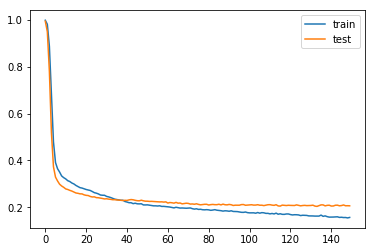

In [270]:

plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()

In [271]:
X_test_reshaped=X_test_scaled.reshape((X_test_scaled.shape[0],1,X_test_scaled.shape[1]))
res1=model2.predict(X_test_reshaped)
test_data['LS_PRED']=res1


/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [272]:
test_data.head(2)



,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,...,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7,LS_PRED,Txn Predicted
726,2015-01-02,33283.114,44,4621,Quito,Pichincha,A,5,2015,1,...,1,5524.0,5745.0,4868.0,4721.0,4813.0,5693.0,7689.0,2.183598,6069
727,2015-01-03,32598.434,44,4364,Quito,Pichincha,A,5,2015,1,...,1,4621.0,5524.0,5745.0,4868.0,4721.0,4813.0,5693.0,1.320237,5436


In [273]:
res2=scaler.inverse_transform(res1)

In [274]:
test_data['Txn Predicted']=res2.astype(int)

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [275]:
test_data.head(5)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,...,dayoff,T_1,T_2,T_3,T_4,T_5,T_6,T_7,LS_PRED,Txn Predicted
726,2015-01-02,33283.114,44,4621,Quito,Pichincha,A,5,2015,1,...,1,5524.0,5745.0,4868.0,4721.0,4813.0,5693.0,7689.0,2.183598,6069
727,2015-01-03,32598.434,44,4364,Quito,Pichincha,A,5,2015,1,...,1,4621.0,5524.0,5745.0,4868.0,4721.0,4813.0,5693.0,1.320237,5436
728,2015-01-04,41727.042,44,5061,Quito,Pichincha,A,5,2015,1,...,1,4364.0,4621.0,5524.0,5745.0,4868.0,4721.0,4813.0,0.585431,4898
729,2015-01-05,30253.240,44,4475,Quito,Pichincha,A,5,2015,2,...,0,5061.0,4364.0,4621.0,5524.0,5745.0,4868.0,4721.0,-0.212100,4314
730,2015-01-06,22941.504,44,3912,Quito,Pichincha,A,5,2015,2,...,0,4475.0,5061.0,4364.0,4621.0,5524.0,5745.0,4868.0,-0.178824,4339


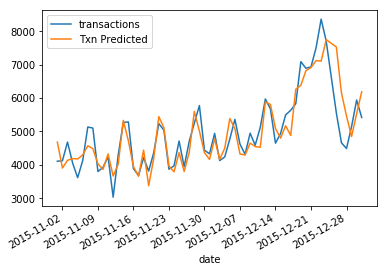

In [278]:
chart=(test_data.date>=pd.to_datetime("11/01/2015")) & (test_data.date<=pd.to_datetime("01/30/2016"))
pred_chart=test_data.loc[chart]
pred_chart=pred_chart[['date','transactions','Txn Predicted']].set_index('date')
plt.figure(figsize=(30,15))
pred_chart.plot()

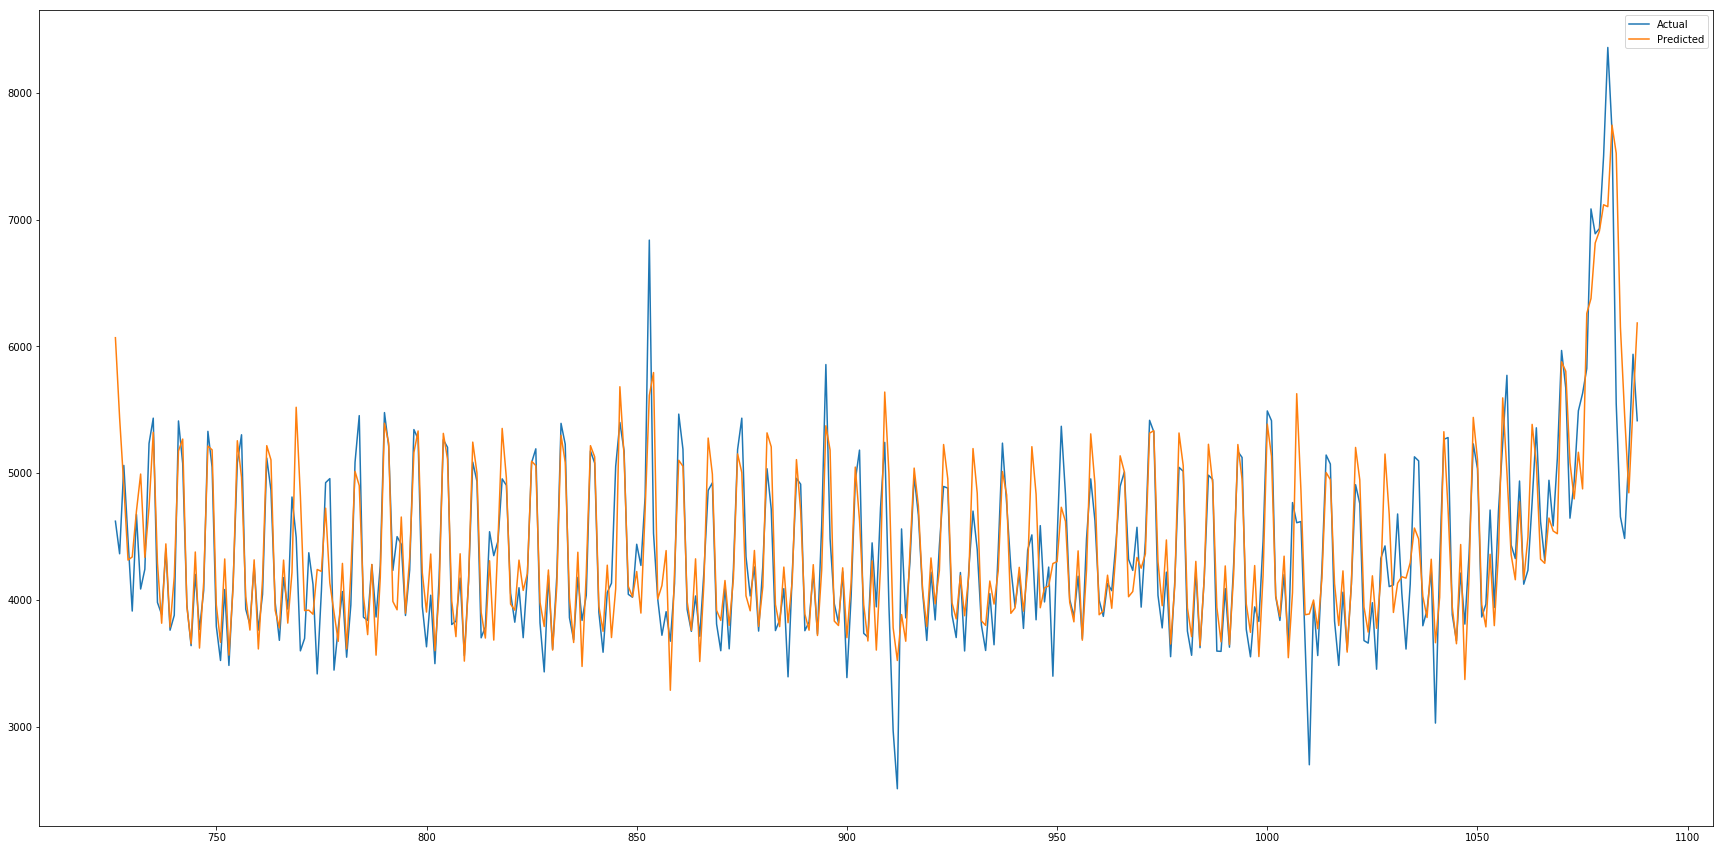

In [279]:
plt.figure(figsize=(30,15))
plt.plot(test_data['transactions'],label='Actual')
plt.plot(test_data['Txn Predicted'],label='Predicted')
plt.legend()

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [293]:
from math import sqrt
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse= sqrt(mean_squared_error(y_test,test_data['Txn Predicted']))
mape = mean_absolute_percentage_error(y_test,test_data['Txn Predicted'])


print("The RMSE Value is : %f" % rmse)
print("The MAPE Value is : %f" % mape)


The RMSE Value is : 376.859160
The MAPE Value is : 56.198347


# Keras Regression on top of LSTM 

In [ ]:
def DL_model2():
    model = Sequential()
    
    model.add(LSTM(10,input_shape=(1,9),kernel_initializer='normal',activation='relu'))
    model.add(Dense(5,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
seed=7
np.random.seed(seed)
estimator=KerasRegressor(build_fn=DL_model2,epochs=50,batch_size=5,verbose=0)
kfold=KFold(n_splits=3,random_state=seed)
results=cross_val_score(estimator,X_clean_reshaped,Y_clean_data_scaled,cv=kfold)
print("Baseline : %.2f(%.2f) MSE" %(results.mean(),results.std()))